In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set seaborn style with default colors
sns.set_style("whitegrid")
sns.set_palette("deep")  # Default seaborn palette

In [49]:
# Load the tuning results
df = pd.read_csv('../data_saving/tuning_iter_400.csv')
df.head()

,lambda,gamma,max_iters,adam,schedule,acc_mean,acc_std,prec_mean,prec_std,rec_mean,rec_std,f1_mean,f1_std,optimal_threshold
0,0.000000,1.0,400,1,nagfree,0.872711,0.001128,0.358564,0.002196,0.559517,0.006280,0.437023,0.001743,0.730534
1,0.000000,1.0,400,1,nagfree,0.872747,0.001116,0.358620,0.002225,0.559310,0.006275,0.437003,0.001870,0.730766
2,0.000001,1.0,400,1,nagfree,0.872473,0.001041,0.358143,0.002032,0.560621,0.005559,0.437051,0.001557,0.730974
3,0.000010,1.0,400,1,nagfree,0.878026,0.000936,0.368824,0.002520,0.535979,0.004204,0.436949,0.002168,0.749571
4,0.000100,1.0,400,1,nagfree,0.876996,0.000790,0.366762,0.001918,0.540846,0.006674,0.437091,0.002618,0.758891


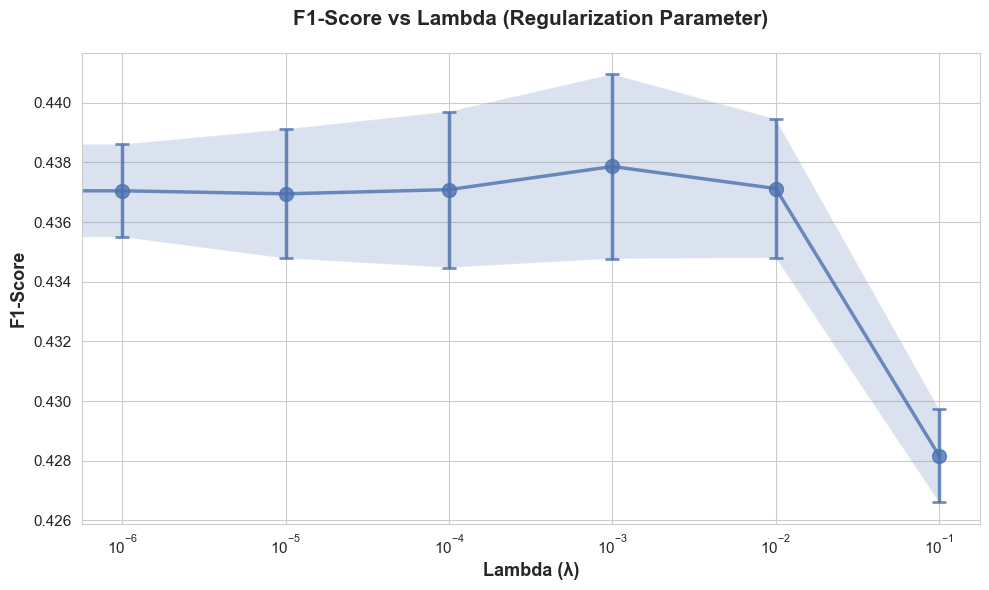

In [50]:
# Plot F1-score vs lambda with seaborn styling
fig, ax = plt.subplots(figsize=(10, 6))

# Plot with error bars using default colors
ax.errorbar(df['lambda'], df['f1_mean'], yerr=df['f1_std'], 
            marker='o', capsize=5, capthick=2, linewidth=2.5, markersize=10,
            alpha=0.8)

# Fill between for shaded error region
ax.fill_between(df['lambda'], 
                df['f1_mean'] - df['f1_std'], 
                df['f1_mean'] + df['f1_std'], 
                alpha=0.2)

ax.set_xscale('log')
ax.set_xlabel('Lambda (λ)', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title('F1-Score vs Lambda (Regularization Parameter)', fontsize=15, fontweight='bold', pad=20)
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.show()

# Plot 2

In [51]:
# Add parent directory to path to import modules
import sys
sys.path.append('..')
import config
import metrics
import implementations
import cv_utils  # Import cv_utils to use find_optimal_threshold

In [52]:
# Find the best hyperparameter configuration
best_config = df.loc[df['f1_mean'].idxmax()]

print(f"Best Model Configuration:")
print(f"  Lambda: {best_config['lambda']:.0e}")
print(f"  Gamma: {best_config['gamma']:.0e}")
print(f"  Max Iters: {int(best_config['max_iters'])}")
print(f"  Optimal Threshold: {best_config['optimal_threshold']:.4f}")
print(f"  F1 Score: {best_config['f1_mean']:.4f} ± {best_config['f1_std']:.4f}")

Best Model Configuration:
  Lambda: 1e-03
  Gamma: 1e+00
  Max Iters: 400
  Optimal Threshold: 0.7853
  F1 Score: 0.4379 ± 0.0031


In [53]:
# Load preprocessed data
import os
preproc_path = os.path.join('..', 'data_saving', 'preproc_data_2.npz')
preproc_data = np.load(preproc_path)
X_train = preproc_data['X_train']
y_train = preproc_data['y_train']
print(f"Loaded preprocessed data from {preproc_path}")
print(f"\nTraining model with best hyperparameters...")
print(f"shape X_train: {X_train.shape}, shape y_train: {y_train.shape}")
# Train the best model
lambda_ = best_config['lambda']
gamma = best_config['gamma']
max_iters = int(best_config['max_iters'])

# Map schedule name to actual function (callable)
import cv_utils
sched_name = str(best_config.get('schedule', 'nagfree'))
if sched_name == 'nagfree':
    schedule_fn = cv_utils.schedule_nagfree
elif sched_name == 'onecycle':
    schedule_fn = cv_utils.schedule_onecycle
else:
    schedule_fn = None

initial_w = np.zeros(X_train.shape[1])
weights, loss = implementations.reg_logistic_regression(
    y_train, X_train, lambda_, initial_w, max_iters, gamma, adam=True, schedule=schedule_fn
)

print("Model training complete!")

Loaded preprocessed data from ..\data_saving\preproc_data_2.npz

Training model with best hyperparameters...
shape X_train: (328135, 835), shape y_train: (328135,)
Model training complete!


In [54]:
# Get predicted probabilities
y_prob = implementations.sigmoid(X_train @ weights)
best_t=best_config['optimal_threshold']
# Find the TRUE optimal threshold using the sophisticated algorithm
true_optimal_threshold, precision_opt, recall_opt, f1_opt = cv_utils.find_optimal_threshold(y_train, y_prob)

print(f"True optimal threshold: {true_optimal_threshold:.4f}")
print(f"F1 at optimal threshold: {f1_opt:.4f}")

# Also compute F1 scores across a range of thresholds for visualization
thresholds = np.linspace(0, 1, 101)  # 101 points from 0 to 1
f1_scores = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    precision, recall, f1 = metrics.precision_recall_f1(y_train, y_pred)
    f1_scores.append(f1)

print(f"F1 Score Range: [{min(f1_scores):.4f}, {max(f1_scores):.4f}]")

True optimal threshold: 0.7840
F1 at optimal threshold: 0.4428
F1 Score Range: [0.0520, 0.4425]


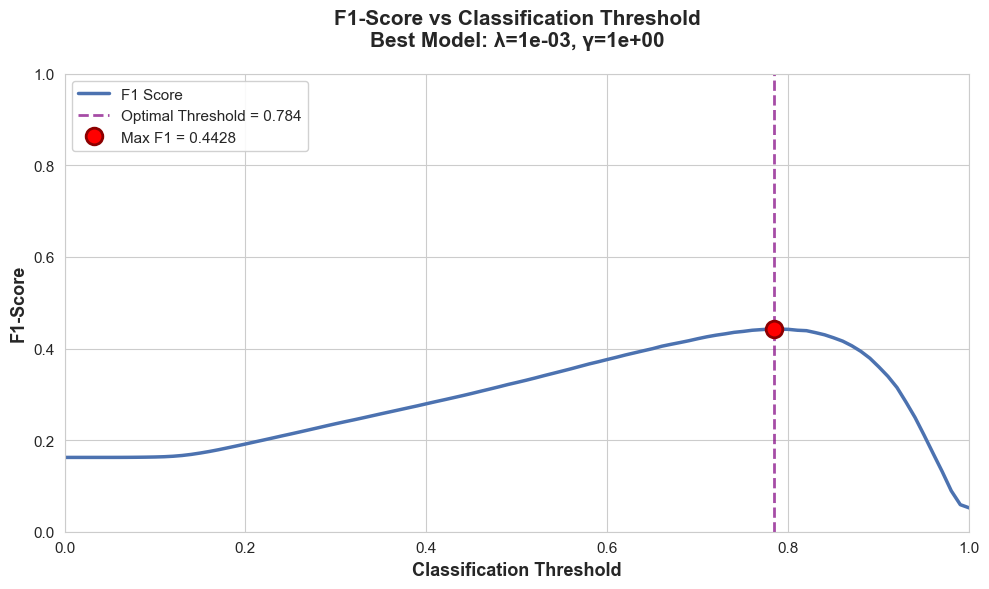

In [55]:
# Plot F1-score vs Threshold
fig, ax = plt.subplots(figsize=(10, 6))

# Plot F1 score
ax.plot(thresholds, f1_scores, linewidth=2.5, label='F1 Score')

# Use the TRUE optimal threshold from find_optimal_threshold function
max_f1_threshold = true_optimal_threshold
max_f1 = f1_opt

# Mark the optimal threshold
ax.axvline(max_f1_threshold, color='purple', linestyle='--', linewidth=2, 
           label=f'Optimal Threshold = {max_f1_threshold:.3f}', alpha=0.7)
ax.plot(max_f1_threshold, max_f1, 'ro', markersize=12, 
        markeredgecolor='darkred', markeredgewidth=2,
        label=f'Max F1 = {max_f1:.4f}', zorder=5)

# Formatting
ax.set_xlabel('Classification Threshold', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title(f'F1-Score vs Classification Threshold\nBest Model: λ={lambda_:.0e}, γ={gamma:.0e}', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.show()

In [56]:
# Compare the thresholds
print(f"Optimal threshold from CSV (CV): {best_config['optimal_threshold']:.4f}")
print(f"Optimal threshold on full train set (using find_optimal_threshold): {true_optimal_threshold:.4f}")
print(f"Difference: {abs(true_optimal_threshold - best_config['optimal_threshold']):.4f}")
print(f"\nThis difference is normal because:")
print(f"  - CSV threshold was computed during cross-validation (averaged across folds)")
print(f"  - Current threshold is computed on the full training set")
print(f"  - Different data splits lead to different optimal thresholds")

Optimal threshold from CSV (CV): 0.7853
Optimal threshold on full train set (using find_optimal_threshold): 0.7840
Difference: 0.0013

This difference is normal because:
  - CSV threshold was computed during cross-validation (averaged across folds)
  - Current threshold is computed on the full training set
  - Different data splits lead to different optimal thresholds


# plot 3

In [ ]:
# Train all 6 models and evaluate them
best_lambda = best_config['lambda']
best_gamma = best_config['gamma']

print("Training all 6 models...")
print(f"Using lambda={best_lambda:.2e}, gamma={best_gamma:.2e}, max_iters={config.FINAL_MAX_ITERS}\n")

results = {}

# 1. Mean Squared Error - Gradient Descent
print("1/6 Training: MSE with Gradient Descent...")
initial_w = np.zeros(X_train.shape[1])
w_mse_gd, _ = implementations.mean_squared_error_gd(y_train, X_train, initial_w, config.FINAL_MAX_ITERS, 1e-2)
y_pred_raw_mse_gd = X_train @ w_mse_gd
threshold_mse_gd, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_pred_raw_mse_gd)
y_pred_mse_gd = (y_pred_raw_mse_gd >= threshold_mse_gd).astype(int)
acc_mse_gd = metrics.accuracy_score(y_train, y_pred_mse_gd)
prec, rec, f1_mse_gd = metrics.precision_recall_f1(y_train, y_pred_mse_gd)
results['MSE-GD'] = {'accuracy': acc_mse_gd, 'f1': f1_mse_gd, 'threshold': threshold_mse_gd}
print(f"   Threshold: {threshold_mse_gd:.4f}, Accuracy: {acc_mse_gd:.4f}, F1: {f1_mse_gd:.4f}")



# 5. Logistic Regression (unregularized)
print("5/6 Training: Logistic Regression...")
initial_w = np.zeros(X_train.shape[1])
w_logreg, _ = implementations.logistic_regression(y_train, X_train, initial_w, config.FINAL_MAX_ITERS, 1e-2)
y_prob_logreg = implementations.sigmoid(X_train @ w_logreg)
threshold_logreg, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_prob_logreg)
y_pred_logreg = (y_prob_logreg >= threshold_logreg).astype(int)
acc_logreg = metrics.accuracy_score(y_train, y_pred_logreg)
prec, rec, f1_logreg = metrics.precision_recall_f1(y_train, y_pred_logreg)
results['Logistic Reg'] = {'accuracy': acc_logreg, 'f1': f1_logreg, 'threshold': threshold_logreg}
print(f"   Threshold: {threshold_logreg:.4f}, Accuracy: {acc_logreg:.4f}, F1: {f1_logreg:.4f}")

# 6. Regularized Logistic Regression
print("6/6 Training: Regularized Logistic Regression...")
initial_w = np.zeros(X_train.shape[1])
w_reg_logreg, _ = implementations.reg_logistic_regression(y_train, X_train, best_lambda, initial_w, config.FINAL_MAX_ITERS, best_gamma,adam=True,schedule=schedule_fn)
y_prob_reg_logreg = implementations.sigmoid(X_train @ w_reg_logreg)
threshold_reg_logreg, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_prob_reg_logreg)
y_pred_reg_logreg = (y_prob_reg_logreg >= threshold_reg_logreg).astype(int)
acc_reg_logreg = metrics.accuracy_score(y_train, y_pred_reg_logreg)
prec, rec, f1_reg_logreg = metrics.precision_recall_f1(y_train, y_pred_reg_logreg)
results['Reg Logistic Reg'] = {'accuracy': acc_reg_logreg, 'f1': f1_reg_logreg, 'threshold': threshold_reg_logreg}
print(f"   Threshold: {threshold_reg_logreg:.4f}, Accuracy: {acc_reg_logreg:.4f}, F1: {f1_reg_logreg:.4f}")

print("\nAll models trained!")

Training all 6 models...
Using lambda=1.00e-03, gamma=1.00e+00, max_iters=400

1/6 Training: MSE with Gradient Descent...
   Threshold: 0.1311, Accuracy: 0.8750, F1: 0.4325
2/6 Training: MSE with SGD...
   Threshold: -9585168165319.0156, Accuracy: 0.0883, F1: 0.1623
3/6 Training: Least Squares...
   Threshold: 0.1388, Accuracy: 0.8788, F1: 0.4353
4/6 Training: Ridge Regression...
   Threshold: 0.1397, Accuracy: 0.8798, F1: 0.4355
5/6 Training: Logistic Regression...
   Threshold: 0.7973, Accuracy: 0.8773, F1: 0.4319
6/6 Training: Regularized Logistic Regression...
   Threshold: 0.7840, Accuracy: 0.8747, F1: 0.4428

All models trained!


In [72]:
# 2. Mean Squared Error - SGD
print("2/6 Training: MSE with SGD...")
initial_w = np.zeros(X_train.shape[1])
w_mse_sgd, _ = implementations.mean_squared_error_sgd(y_train, X_train, initial_w, config.FINAL_MAX_ITERS, 5e-4)
y_pred_raw_mse_sgd = X_train @ w_mse_sgd
threshold_mse_sgd, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_pred_raw_mse_sgd)
y_pred_mse_sgd = (y_pred_raw_mse_sgd >= threshold_mse_sgd).astype(int)
acc_mse_sgd = metrics.accuracy_score(y_train, y_pred_mse_sgd)
prec, rec, f1_mse_sgd = metrics.precision_recall_f1(y_train, y_pred_mse_sgd)
results['MSE-SGD'] = {'accuracy': acc_mse_sgd, 'f1': f1_mse_sgd, 'threshold': threshold_mse_sgd}
print(f"   Threshold: {threshold_mse_sgd:.4f}, Accuracy: {acc_mse_sgd:.4f}, F1: {f1_mse_sgd:.4f}")


2/6 Training: MSE with SGD...
   Threshold: 0.1052, Accuracy: 0.8132, F1: 0.3204


In [77]:
# 3. Least Squares
print("3/6 Training: Least Squares...")
w_ls, _ = implementations.ridge_regression(y_train, X_train, 1e-15)
#w_ls,_= implementations.least_squares(y_train, X_train)
y_pred_raw_ls = X_train @ w_ls
threshold_ls, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_pred_raw_ls)
y_pred_ls = (y_pred_raw_ls >= threshold_ls).astype(int)
acc_ls = metrics.accuracy_score(y_train, y_pred_ls)
prec, rec, f1_ls = metrics.precision_recall_f1(y_train, y_pred_ls)
results['Least Squares'] = {'accuracy': acc_ls, 'f1': f1_ls, 'threshold': threshold_ls}
print(f"   Threshold: {threshold_ls:.4f}, Accuracy: {acc_ls:.4f}, F1: {f1_ls:.4f}")


3/6 Training: Least Squares...
   Threshold: 0.1384, Accuracy: 0.8788, F1: 0.4351


In [ ]:
# 4. Ridge Regression
print("4/6 Training: Ridge Regression...")
w_ridge, _ = implementations.ridge_regression(y_train, X_train, best_lambda)
y_pred_raw_ridge = X_train @ w_ridge
threshold_ridge, _, _, _ = cv_utils.find_optimal_threshold(y_train, y_pred_raw_ridge)
y_pred_ridge = (y_pred_raw_ridge >= threshold_ridge).astype(int)
acc_ridge = metrics.accuracy_score(y_train, y_pred_ridge)
prec, rec, f1_ridge = metrics.precision_recall_f1(y_train, y_pred_ridge)
results['Ridge'] = {'accuracy': acc_ridge, 'f1': f1_ridge, 'threshold': threshold_ridge}
print(f"   Threshold: {threshold_ridge:.4f}, Accuracy: {acc_ridge:.4f}, F1: {f1_ridge:.4f}")


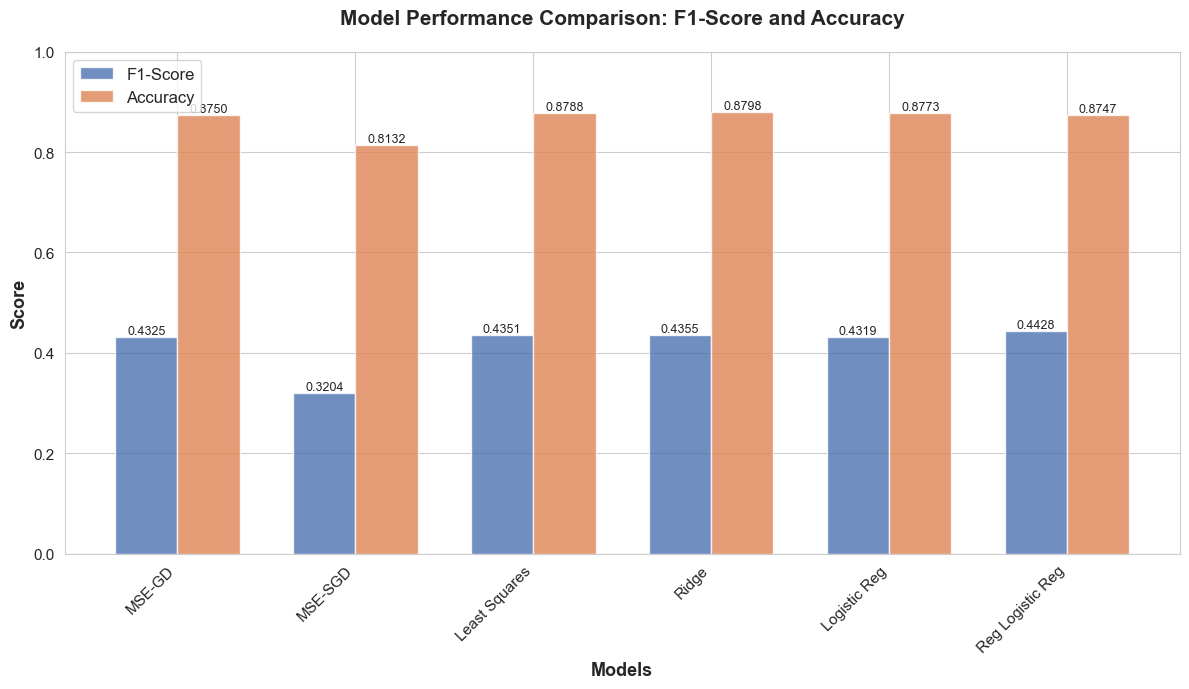

In [ ]:
# Create grouped bar plot
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
f1_scores = [results[m]['f1'] for m in model_names]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(model_names))  # Label locations
width = 0.35  # Width of bars

# Create bars
bars1 = ax.bar(x - width/2, f1_scores, width, label='F1-Score', alpha=0.8)
bars2 = ax.bar(x + width/2, accuracies, width, label='Accuracy', alpha=0.8)

# Formatting
ax.set_xlabel('Models', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Model Performance Comparison: F1-Score and Accuracy', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim([0, 1])
ax.legend(fontsize=12, loc='upper left')
ax.tick_params(labelsize=11)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout() 
plt.show()

In [59]:
# Print detailed results to see exact values
print("Detailed Results:")
print("-" * 60)
print(f"{'Model':<20} {'Accuracy':>12} {'F1-Score':>12}")
print("-" * 60)
for model_name in results.keys():
    acc = results[model_name]['accuracy']
    f1 = results[model_name]['f1']
    print(f"{model_name:<20} {acc:>12.4f} {f1:>12.4f}")
print("-" * 60)

Detailed Results:
------------------------------------------------------------
Model                    Accuracy     F1-Score
------------------------------------------------------------
MSE-GD                     0.9117       0.0000
MSE-SGD                    0.9117       0.0000
Least Squares              0.8788       0.4353
Ridge                      0.8798       0.4355
Logistic Reg               0.7360       0.2736
Reg Logistic Reg           0.8747       0.4428
------------------------------------------------------------
